In [99]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

## Load data

In [2]:
df_train = pd.read_csv("data/ADNIMERGE_train.csv")
df_test = pd.read_csv("data/ADNIMERGE_test.csv")

In [3]:
X_train = df_train.drop(['RID', 'DX_bl'], axis=1).copy()
y_train = df_train['DX_bl'].copy()
X_test = df_test.drop(['RID', 'DX_bl'], axis=1).copy()
y_test = df_test['DX_bl'].copy()

## Significance of Predictors

We would like to find out the most significant variables in the model. These variables have the strongest predicting power, and are thus the most useful in the diagnosis of Alzheimer's disease. Identifying these variables can eliminate the number of tests a patient has to go through to get an accurate diagnosis. 

For logistic regression with l1 regularization, we used bootstraping (1000 iterations) to find the most significant predictors. For random forest, we chcked the returned attribute `feature_importances_`.

### Bootstrap

In [38]:
log_l1 = LogisticRegressionCV(penalty = 'l1', solver = 'liblinear')
log_l1.fit(X_train,y_train)
c = log_l1.C_[0]

iterations = 200
boot = np.zeros((X_train.shape[1], iterations))
for i in range(iterations):
    seed = 2*i
    boot_rows = np.random.choice(range(X_train.shape[0]),
                                 size=X_train.shape[0], replace=True)
    X_train_boot = X_train.values[boot_rows]
    y_train_boot = y_train.values[boot_rows]
    model_boot = LogisticRegression(penalty = 'l1', C=c)
    model_boot.fit(X_train_boot, y_train_boot)
    boot[:,i] = model_boot.coef_[2,:]
    
boot_ci_upper = np.percentile(boot, 95, axis=1)
boot_ci_lower = np.percentile(boot, 5, axis=1)
sig_b_ct = []
for i in range(X_train.shape[1]):
    if boot_ci_upper[i]<0 or boot_ci_lower[i]>0:
        sig_b_ct.append(i)
        
print("Most significant coefficients: ",len(sig_b_ct))
print(X_train.columns[sig_b_ct])

Most significant coefficients:  5
Index(['ADAS13', 'MMSE', 'RAVLT_immediate', 'RAVLT_forgetting', 'FAQ'], dtype='object')


Surprisingly, we only have 5 significant predictors using bootstrap method and all of them are cognitive assessments which don't cost as much as brain imaing tests. Specifically, the significant assessments are: 
- **`ADAS13`**: Alzheimer’s Disease Assessment Scale
- **`MMSE`**: Mini-Mental State Examination
- **`RAVLT_immediate`**: Rey Auditory Verbal Learning Test (immediate??)
- **`RAVLT_forgetting`**: Rey Auditory Verbal Learning Test (forgetting??)
- **`FAQ`**: Functional Activities Questionnaire in Older Adults with Dementia. 
We found this result a bit doubtful because no brain imaging tests are picked as significant predictors while studies have shown the great important role of brain imaging in diagnosing Alzheimer's Disease. However, if other models also give similar result, patients are likely to save a lot of money and time. 

### Feature importance

In [116]:
rf_best = RandomForestClassifier(n_estimators=16, max_depth=8,random_state=9001)
rf_best.fit(X_train, y_train)
imp_features = np.array(X_train.columns)[rf_best.feature_importances_!=0]
print("The most important {} features:".format(len(imp_features)))
print(imp_features)

The most important 69 features:
['PTGENDER' 'PTEDUCAT' 'PTRACCAT_Asian' 'PTRACCAT_Black'
 'PTETHCAT_Not_Hisp/Latino' 'PTMARRY_Never_married' 'PTMARRY_Widowed'
 'APOE4' 'CSF_ABETA' 'CSF_TAU' 'CSF_PTAU' 'FDG' 'FDG_slope' 'AV45'
 'AV45_slope' 'ADAS13' 'ADAS13_slope' 'MMSE' 'MMSE_slope' 'RAVLT_immediate'
 'RAVLT_immediate_slope' 'RAVLT_learning' 'RAVLT_learning_slope'
 'RAVLT_forgetting' 'RAVLT_forgetting_slope' 'RAVLT_perc_forgetting'
 'RAVLT_perc_forgetting_slope' 'MOCA' 'MOCA_slope' 'EcogPtMem'
 'EcogPtMem_slope' 'EcogPtLang' 'EcogPtLang_slope' 'EcogPtVisspat'
 'EcogPtVisspat_slope' 'EcogPtPlan' 'EcogPtPlan_slope' 'EcogPtOrgan'
 'EcogPtOrgan_slope' 'EcogPtDivatt' 'EcogPtDivatt_slope' 'EcogSPMem'
 'EcogSPMem_slope' 'EcogSPLang' 'EcogSPLang_slope' 'EcogSPVisspat'
 'EcogSPVisspat_slope' 'EcogSPPlan' 'EcogSPPlan_slope' 'EcogSPOrgan'
 'EcogSPOrgan_slope' 'EcogSPDivatt' 'EcogSPDivatt_slope' 'FAQ' 'FAQ_slope'
 'Ventricles' 'Ventricles_slope' 'Hippocampus' 'Hippocampus_slope'
 'WholeBrain' 'Who

In [118]:
rf_best.feature_importances_

array([ 0.00087767,  0.0020059 ,  0.00143294,  0.0005828 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00050201,  0.        ,
        0.00060242,  0.00118299,  0.0028174 ,  0.01467083,  0.01258936,
        0.00697837,  0.02477119,  0.01673831,  0.01182501,  0.01354028,
        0.04849771,  0.01839468,  0.11457045,  0.03074313,  0.01879795,
        0.00570639,  0.00371095,  0.00934691,  0.0062503 ,  0.0101368 ,
        0.01614024,  0.00521234,  0.0140865 ,  0.01044318,  0.0458762 ,
        0.01264462,  0.02719033,  0.00866986,  0.00973303,  0.00541363,
        0.0076151 ,  0.0139272 ,  0.01034697,  0.01114828,  0.01117674,
        0.01566404,  0.02683175,  0.02202945,  0.01870235,  0.01569833,
        0.02035809,  0.00540625,  0.02188036,  0.00703498,  0.02768822,
        0.01459536,  0.00260903,  0.00995034,  0.0692315 ,  0.01662022,
        0.00934408,  0.00954604,  0.01622423,  0.00360556,  0.00575205,
        0.01142386,  0.00604743,  0.00299329,  0.01299582,  0.01

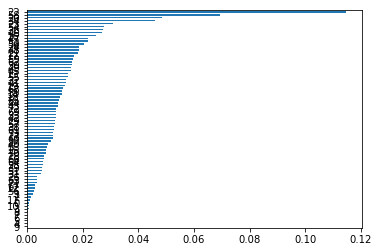

In [122]:
pd.Series(rf_best.feature_importances_).sort_values().plot(kind='barh')
plt.show()

In [68]:
imp = rf_best.feature_importances_
ranks_rf = np.searchsorted(np.sort(imp), imp)
ranks_rf=len(ranks_rf)-ranks_rf
ranks_rf


array([66, 63, 64, 68, 74, 74, 74, 74, 69, 74, 67, 65, 61, 22, 29, 48,  9,
       16, 30, 26,  3, 15,  1,  5, 13, 53, 57, 43, 50, 38, 19, 56, 24, 36,
        4, 28,  7, 45, 40, 54, 46, 25, 37, 33, 32, 21,  8, 10, 14, 20, 12,
       55, 11, 47,  6, 23, 62, 39,  2, 17, 44, 41, 18, 58, 52, 31, 51, 60,
       27, 35, 49, 59, 34, 42])

In [76]:
ranked_x_rf = [None]*len(X_train.columns)
for i, rank in enumerate(ranks_rf):
    ranked_x_rf[rank-1] = X_train.columns[i]
print('Ranked Predictors by Random Forest Feature Importance:\n')
print(ranked_x_rf)

Ranked Predictors by Random Forest Feature Importance:

['MMSE', 'FAQ', 'ADAS13', 'EcogPtMem', 'MMSE_slope', 'EcogSPOrgan', 'EcogPtLang', 'EcogSPMem', 'FDG', 'EcogSPMem_slope', 'EcogSPPlan', 'EcogSPVisspat', 'RAVLT_immediate', 'EcogSPLang', 'ADAS13_slope', 'FDG_slope', 'FAQ_slope', 'Hippocampus', 'RAVLT_perc_forgetting', 'EcogSPLang_slope', 'EcogPtDivatt_slope', 'CSF_ABETA', 'EcogSPOrgan_slope', 'MOCA', 'EcogPtPlan_slope', 'AV45_slope', 'Fusiform', 'EcogPtMem_slope', 'CSF_TAU', 'AV45', 'WholeBrain_slope', 'EcogPtDivatt', 'EcogPtOrgan_slope', 'ICV', 'Fusiform_slope', 'MOCA_slope', 'EcogPtOrgan', 'RAVLT_forgetting_slope', 'EcogSPDivatt_slope', 'EcogPtVisspat', 'Ventricles_slope', 'ICV_slope', 'RAVLT_learning_slope', 'Ventricles', 'EcogPtLang_slope', 'EcogPtPlan', 'EcogSPPlan_slope', 'CSF_PTAU', 'MidTemp', 'RAVLT_forgetting', 'Entorhinal', 'WholeBrain', 'RAVLT_immediate_slope', 'EcogPtVisspat_slope', 'EcogSPVisspat_slope', 'RAVLT_perc_forgetting_slope', 'RAVLT_learning', 'Hippocampus_slop

Using random forest classifier, we ended up with 69 important features. 
Only `PTRACCAT_Hawaiian/Other_PI`,`PTRACCAT_More_than_one`, `PTRACCAT_Unknown`, `PTRACCAT_White`, `PTMARRY_Married` are not significant, all of which are indicators of race and marriage. Notably, among the most important predictors, `MMSE`, `FAQ`, and `ADAS13` appear again (also appeared in bootstraping result), which adds even more significance to these cognition tests.

## Forward and Backward Selection

In [105]:
def step_forwards_backwards(direction='forward'):
    

    
    assert direction in ['forward', 'backward']

    predictors = set(X_train.columns)
    predictors_ls = list(X_train.columns)
    selected_predictors = set() if direction=='forward' else set(predictors)
    
    n = X_train.shape[0]
    best_acc = np.inf
    
    best_accuracy = []
    best_models = []
    
    rank = 0
    
    if direction == 'forward':
        ranks = [len(predictors_ls)-1]*len(predictors_ls)
        X = X_train[list(selected_predictors)].values
        while (True):
            
            possible_scores = []
            possible_predictors = list(selected_predictors ^ predictors)
            
            if len(possible_predictors) == 0:
                break
                
            for predictor in possible_predictors:
                cv_fold = KFold(n_splits=3, shuffle=True, random_state=9001)
                x_temp = np.concatenate([X, X_train[predictor].values.reshape(-1,1)], axis=1)
                rf = RandomForestClassifier(n_estimators=16, max_depth=8,random_state=9001)
                #rf.fit(x_temp, y_train)
                scores = max(cross_val_score(rf, x_temp, y_train, cv=cv_fold))
                #scores = rf.cross_val_score(x_temp, y_train)
                possible_scores.append(scores)
                
            best_predictor_ix = np.argmax(possible_scores)
            best_predictor = possible_predictors[best_predictor_ix]
            ranks[predictors_ls.index(best_predictor)]=rank
            
            best_acc = np.max(possible_scores)
            best_accuracy.append(best_acc)
            
            selected_predictors.add(best_predictor)            
            X = np.concatenate([X, X_train[best_predictor].values.reshape(-1,1)], axis=1)
            best_models.append(list(selected_predictors))
            
            rank += 1

    else:
        ranks = [0]*len(predictors_ls)
        while (True):
            possible_scores = []
            possible_predictors = list(selected_predictors)

            if len(possible_predictors) == 0:
                break

            for predictor in possible_predictors:
                cv_fold = KFold(n_splits=3, shuffle=True, random_state=9001)                
                X = np.concatenate([np.ones(n).reshape(-1,1), 
                                    X_train[list(selected_predictors - set([predictor]))].values], 
                                   axis=1)
                if(X.shape[1] != 0):
                    rf = RandomForestClassifier(n_estimators=16, max_depth=8,random_state=9001)
                    #rf.fit(X, y_train)
                    scores = max(cross_val_score(rf, X, y_train, cv=cv_fold))
                    #scores = rf.cross_val_score(x_temp, y_train)
                    possible_scores.append(scores)

            best_predictor_ix = np.argmax(possible_scores)
            best_predictor = possible_predictors[best_predictor_ix] 
            ranks[predictors_ls.index(best_predictor)]=len(predictors_ls)-rank-1

            best_acc = possible_scores[best_predictor_ix]
            selected_predictors.discard(best_predictor)
            
            best_accuracy.append(best_acc)
            best_models.append(list(selected_predictors))
            
            rank += 1
            
    index_of_best_accuracy = np.argmax(best_accuracy)

    return (best_models[index_of_best_accuracy],ranks)

In [106]:
predictors_forward,ranks_f = step_forwards_backwards(direction='forward')
predictors_backward,ranks_b = step_forwards_backwards(direction='backward')

In [107]:
print("Predictors selected by forward selection (", 
      len(predictors_forward), " predictors): \n", predictors_forward,'\n',ranks_f)
print("\n-----------------------------------------\n")
print("Predictors selected by backward selection: (", 
      len(predictors_backward), " predictors): \n", predictors_backward,'\n',ranks_b)

Predictors selected by forward selection ( 14  predictors): 
 ['MMSE', 'EcogSPMem', 'EcogSPLang', 'FDG_slope', 'EcogPtMem', 'EcogPtVisspat_slope', 'CSF_TAU', 'WholeBrain_slope', 'RAVLT_learning_slope', 'FAQ_slope', 'EcogPtOrgan_slope', 'EcogSPMem_slope', 'Hippocampus', 'RAVLT_forgetting_slope'] 
 [65, 68, 17, 47, 15, 46, 30, 69, 51, 67, 27, 38, 60, 31, 5, 41, 56, 10, 28, 33, 22, 20, 0, 48, 53, 49, 44, 3, 29, 8, 40, 23, 19, 39, 6, 73, 35, 26, 50, 12, 70, 71, 52, 13, 18, 64, 1, 7, 4, 25, 57, 37, 16, 61, 54, 58, 45, 21, 42, 11, 59, 43, 9, 72, 66, 2, 63, 24, 55, 34, 32, 14, 62, 36]

-----------------------------------------

Predictors selected by backward selection: ( 21  predictors): 
 ['PTRACCAT_Hawaiian/Other_PI', 'MMSE', 'FDG_slope', 'RAVLT_forgetting', 'WholeBrain', 'EcogPtDivatt_slope', 'Fusiform_slope', 'EcogPtLang', 'EcogSPMem_slope', 'PTMARRY_Married', 'CSF_PTAU', 'WholeBrain_slope', 'FAQ_slope', 'AV45_slope', 'FAQ', 'PTRACCAT_White', 'EcogSPPlan_slope', 'Fusiform', 'EcogSPLang',

In [108]:
ranked_x_forward = [None]*len(X_train.columns)
for i, rank in enumerate(ranks_f):
    ranked_x_forward[rank] = X_train.columns[i]
print('Ranked Predictors by Forward Selection:\n')
print(ranked_x_forward)

Ranked Predictors by Forward Selection:

['MMSE', 'EcogSPMem', 'WholeBrain_slope', 'RAVLT_learning_slope', 'EcogSPLang', 'CSF_TAU', 'EcogPtMem', 'EcogSPMem_slope', 'RAVLT_forgetting_slope', 'Hippocampus', 'FDG_slope', 'FAQ_slope', 'EcogPtVisspat_slope', 'EcogPtOrgan_slope', 'MidTemp_slope', 'PTRACCAT_Hawaiian/Other_PI', 'EcogSPPlan', 'PTRACCAT_Asian', 'EcogPtDivatt', 'MOCA', 'ADAS13_slope', 'EcogSPDivatt_slope', 'ADAS13', 'RAVLT_perc_forgetting_slope', 'Entorhinal_slope', 'EcogSPLang_slope', 'EcogPtLang_slope', 'PTMARRY_Never_married', 'AV45', 'RAVLT_forgetting', 'PTRACCAT_Unknown', 'CSF_ABETA', 'MidTemp', 'AV45_slope', 'Fusiform_slope', 'EcogPtLang', 'ICV_slope', 'EcogSPVisspat_slope', 'PTMARRY_Widowed', 'MOCA_slope', 'RAVLT_perc_forgetting', 'CSF_PTAU', 'FAQ', 'Ventricles_slope', 'RAVLT_learning', 'EcogSPDivatt', 'PTRACCAT_More_than_one', 'PTRACCAT_Black', 'MMSE_slope', 'RAVLT_immediate_slope', 'EcogPtVisspat', 'PTETHCAT_Not_Hisp/Latino', 'EcogPtOrgan', 'RAVLT_immediate', 'EcogSPOrga

In [109]:
ranked_x_backward = [None]*len(X_train.columns)
for i, rank in enumerate(ranks_b):
    ranked_x_backward[rank] = X_train.columns[i]
print('Ranked Predictors by Backward Selection:\n')
print(ranked_x_backward)

Ranked Predictors by Backward Selection:

['MMSE', 'FDG_slope', 'FAQ_slope', 'FAQ', 'Fusiform', 'CSF_PTAU', 'EcogPtLang', 'EcogPtDivatt_slope', 'WholeBrain', 'PTRACCAT_Hawaiian/Other_PI', 'EcogSPLang', 'EcogSPPlan_slope', 'WholeBrain_slope', 'AV45_slope', 'EcogSPOrgan_slope', 'RAVLT_forgetting', 'APOE4', 'Fusiform_slope', 'PTRACCAT_White', 'PTMARRY_Married', 'EcogSPMem_slope', 'PTETHCAT_Not_Hisp/Latino', 'EcogPtVisspat_slope', 'RAVLT_perc_forgetting', 'EcogSPVisspat', 'CSF_ABETA', 'PTMARRY_Never_married', 'PTRACCAT_Unknown', 'Ventricles_slope', 'CSF_TAU', 'ADAS13', 'Hippocampus', 'MOCA_slope', 'EcogSPOrgan', 'EcogPtMem_slope', 'EcogPtPlan', 'EcogPtVisspat', 'RAVLT_learning', 'EcogPtDivatt', 'RAVLT_forgetting_slope', 'PTMARRY_Widowed', 'EcogSPPlan', 'MOCA', 'Hippocampus_slope', 'ICV_slope', 'AV45', 'EcogPtLang_slope', 'MidTemp', 'EcogSPDivatt', 'MMSE_slope', 'RAVLT_perc_forgetting_slope', 'Ventricles', 'Entorhinal', 'RAVLT_learning_slope', 'EcogPtPlan_slope', 'PTRACCAT_More_than_one', '

Backward selection chose a bit more predictors than forward selection.

By comparing the ranks of predictors generated by stepwise selections, `EcogSPMem`, `FDG`,`MMSE`,``
We can see that genetic analysis such as `APOE4`, CSF biosamples, neuropsychological tests and MRI are the most important varibles in predicting AD. However, only a few variables we get from each of tests are useful, so we do not need to focus on all the testing results. 

Also, notably, we found that it is necessary to take the cognitive assessments and perform brain scan multiple times to check the progress of cognitive decline and brain atrophy. These are very indicative of AD. For the other categories, one test is sufficient for the diagnosis of AD. Going through the same test multiple times will not increase predictability.

In [110]:
forward = set(predictors_forward)
backward = set(predictors_backward)
inter_f_b = forward.intersection(backward)
inter_f_b_rf = inter_f_b.intersection(imp_features)
print('Common significant predictors by random forest, forward, and backward selection:\n')
print(inter_f_b_rf)

Common significant predictors by random forest, forward, and backward selection:

{'MMSE', 'EcogSPLang', 'WholeBrain_slope', 'FAQ_slope', 'EcogSPMem_slope', 'FDG_slope'}


The tests completed excluded are: `AV45`, `MMSE`, `MOCA`, and `FAQ`. Since `MMSE` and `FAQ` are selected as significant predictors by bootstraping, it's more reaonable to conclude that only `AV45` and `MOCA` tests are not necessary for the diagnosis of AD.

The factors that are significant themselves but insignificant in their slopes are:`MOCA`, `EcogPtLang`, `EcogSPPlan`, `EcogPtDivatt`, `EcogSPOrgan`, and `Fusiform`, which indicates that tests associated with these factors only need to be conducted once at baseline visit and are not necessary in the following visits. Specifically, MOCA(Montreal Cognitive Assessment) test, Everyday Cognition test on Participant Language, Study Partner Plan, 

The factors that are significant only in their slopes are: `ADAS13`,
`EcogPlan`, `EcogSPLang`, and `ICV`, which means the change in these parameters within two years after the first visit is quite important for the diagnosis. So testing these parameters on each visit is necessary. Specifically, the factors selected are from **Ecog** (Everyday Cognition)test and **MRI** test.

Other significant demographic factors: `PTEDUCAT`, and `PTETHCAT_Not_Hisp/Latino`


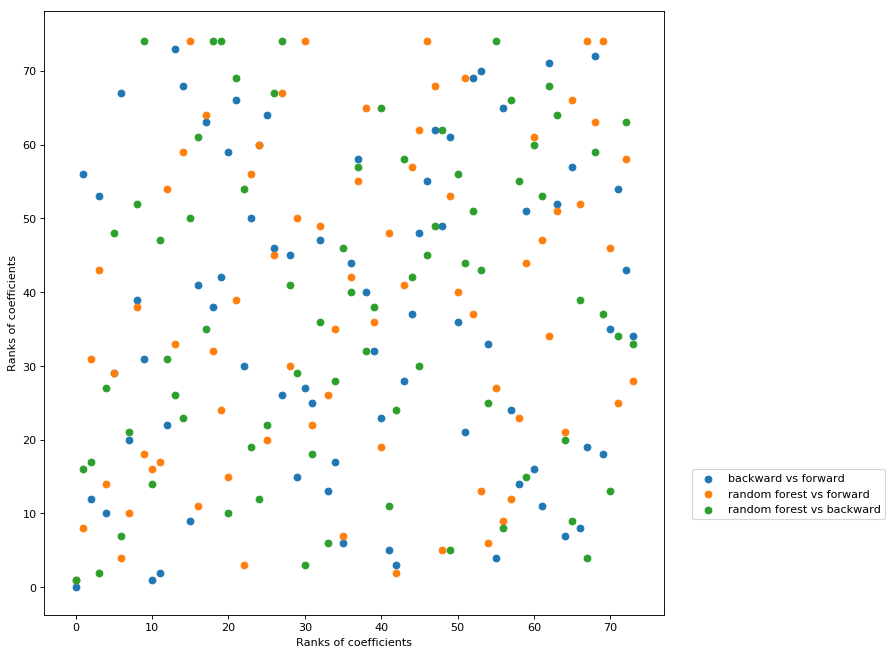

In [115]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
#ax1 = fig.add_subplot(111)
plt.scatter(ranks_f,ranks_b,label='backward vs forward')
plt.scatter(ranks_f,ranks_rf,label='random forest vs forward')
plt.scatter(ranks_b,ranks_rf,label='random forest vs backward')



#plt.plot(ranks_f,ranks_b,label='backward vs forward',alpha=0.2)
#plt.plot(ranks_f,ranks_rf,label='random forest vs forward',alpha=0.2)
#plt.plot(ranks_b,ranks_rf,label='random forest vs backward',alpha=0.2)

plt.legend(loc='center', bbox_to_anchor=(1.2, 0.2), ncol=1)
plt.xlabel('Ranks of coefficients')
plt.ylabel('Ranks of coefficients')
plt.show()

### NOT ALIGNED AT ALL....

In [142]:
def rank_compare(rank_list_1, rank_list_2):
    N = len(rank_list_1)
    sim = 0
    for i in range(N):
        for j in range(i, N):
            sim += ( (rank_list_1[i] > rank_list_1[j]) == (rank_list_2[i] > rank_list_2[j]) )
    sim /= N*(N-1) / 2
    return sim

In [144]:
rank_compare(ranks_rf[:10], ranks_f[:10])

0.73333333333333328